# Imports

In [1]:
from keras.preprocessing.image import ImageDataGenerator, DirectoryIterator
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D
from keras.layers import Activation,Dropout,Flatten,Dense
from keras import backend as K
from keras import regularizers

import numpy as np
from keras.preprocessing import image
import tensorflow.keras.metrics

import matplotlib.pyplot as plt

import pandas as pd
import os
import shutil
import sys

Using TensorFlow backend.


In [2]:
import tensorflow as tf
tf.random.set_seed(19830502)

# Variable definitions

In [3]:

image_width,img_height = 150,150

train_data_dir = 'morel_classifier_images/train'
test_data_dir = 'morel_classifier_images/test'

nb_train_samples = 200
nb_test_samples = 20
reg_num = 0.0001

epochs = 60
batch_size = 36 # Use powers of 2

# Generate the data from the images

In [4]:
if K.image_data_format() =='channels_first':
    input_shape = (3,image_width,img_height)
else:
    input_shape = (image_width,img_height,3)

In [5]:
train_datagen = ImageDataGenerator(
                            rescale= (1.0 /255),
                            shear_range =0.4,
                            zoom_range = 0.4,
                            horizontal_flip = True,
                            vertical_flip= True
                                    )

In [6]:
test_datagen = ImageDataGenerator( rescale= 1.0/255)

In [7]:
train_generator = train_datagen.flow_from_directory(
                                                    train_data_dir,
                                                    target_size=(image_width,img_height),
                                                    batch_size=batch_size,
                                                    class_mode = 'binary'
                                                    )

Found 1740 images belonging to 2 classes.


In [8]:
test_generator = test_datagen.flow_from_directory(
                                                test_data_dir,
                                                target_size=(image_width,img_height),
                                                batch_size=batch_size,
                                                class_mode='binary'
                                                    )

Found 616 images belonging to 2 classes.


# Start the model

In [9]:
model = Sequential()

In [10]:
# First layer - input image
model.add(Conv2D(255,
                 kernel_size= (3,3), 
                 input_shape=input_shape, 
                 activation='relu',
                ))
model.add(MaxPooling2D(pool_size=(2,2)))

In [11]:
# hidden layers
model.add(Conv2D(128,
                 kernel_size=(3,3),
                 activation='relu',
#                  kernel_regularizer=regularizers.l2(reg_num)
                ))
model.add(Dropout(.1))
model.add(MaxPooling2D(pool_size=(2,2)))

In [12]:
model.add(Conv2D(64,
                 kernel_size=(3,3),
                 activation='relu',
#                  kernel_regularizer=regularizers.l2(reg_num)
                ))
model.add(Dropout(.1))
model.add(MaxPooling2D(pool_size=(2,2)))

In [13]:
model.add(Conv2D(32,
                 kernel_size=(3,3),
                 activation='relu',
#                  kernel_regularizer=regularizers.l2(reg_num)
                ))
model.add(Dropout(.1))
model.add(MaxPooling2D(pool_size=(2,2)))

In [14]:
# flatten
model.add(Flatten(input_shape=input_shape))


In [15]:
# Dense Layers
model.add(Dense(64, 
                activation='relu',
               ))
model.add(Dropout(.1))

model.add(Dense(32, 
                activation='relu',
               ))
model.add(Dropout(.1))

model.add(Dense(25, 
                activation='relu',
               ))
model.add(Dropout(.1))

In [16]:
# final output layer
model.add(Dense(1, activation = 'sigmoid'))

In [17]:
model.compile( 
    loss = 'binary_crossentropy',
    optimizer='adam',
    metrics=['acc']
                )

In [18]:
history = model.fit_generator(
            train_generator,
            steps_per_epoch= nb_train_samples // batch_size,
            epochs=epochs,
            validation_data=test_generator,
            validation_steps=nb_test_samples // batch_size,
)

model.save('history/morel_class_try.h5')

Epoch 1/60
5/5 [==============================] - 137s 27s/step - loss: 0.6959 - acc: 0.5278 - val_loss: 0.6967 - val_acc: 0.4886
Epoch 2/60
5/5 [==============================] - 119s 24s/step - loss: 0.6986 - acc: 0.4389 - val_loss: 0.6951 - val_acc: 0.5195
Epoch 3/60
5/5 [==============================] - 115s 23s/step - loss: 0.6965 - acc: 0.4833 - val_loss: 0.6945 - val_acc: 0.4724
Epoch 4/60
5/5 [==============================] - 114s 23s/step - loss: 0.6985 - acc: 0.4500 - val_loss: 0.6919 - val_acc: 0.4724
Epoch 5/60
5/5 [==============================] - 111s 22s/step - loss: 0.6937 - acc: 0.4103 - val_loss: 0.6932 - val_acc: 0.5016
Epoch 6/60
5/5 [==============================] - 111s 22s/step - loss: 0.6935 - acc: 0.4278 - val_loss: 0.6927 - val_acc: 0.5260
Epoch 7/60
5/5 [==============================] - 112s 22s/step - loss: 0.6934 - acc: 0.4722 - val_loss: 0.6949 - val_acc: 0.4724
Epoch 8/60
5/5 [==============================] - 115s 23s/step - loss: 0.6931 - acc: 0.52

# Plot the data

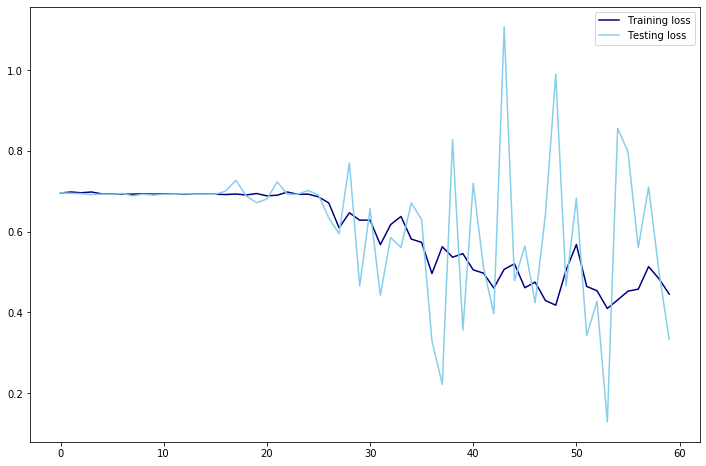

In [19]:
train_loss = history.history['loss']
test_loss = history.history['val_loss']
plt.figure(figsize=(12, 8))
plt.plot(train_loss, label='Training loss', color='navy')
plt.plot(test_loss, label='Testing loss', color='skyblue')
plt.legend()
plt.savefig('figures/morel_loss.png');

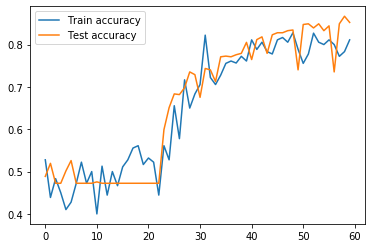

In [20]:
plt.plot(history.history['acc'], label='Train accuracy')
plt.plot(history.history['val_acc'], label='Test accuracy')
plt.legend()
plt.savefig('figures/morel_acc.png');

# Test single image

In [21]:
# img_pred = image.load_img('morel_classifier_images/Test/1_not_good_morels/OIP - 2020-03-04T145542.245.jpeg',
#                           target_size=(img_height,image_width))

# img_pred = image.img_to_array(img_pred)
# img_pred = np.expand_dims(img_pred, axis = 0)

In [22]:
# result = model.predict_classes(img_pred)

In [23]:
# print(result)

In [24]:
# if result[0][0] == 1:
#     prediction = 'bad morel bad'
# else:
#     prediction = 'good morel'
    
# print(prediction)

# Make Predictions on False Mushrooms

In [25]:
#Create list for each image to be predicted on
false_folder_list = sorted(os.listdir(f'morel_classifier_images/Test/1_not_good_morels'))
false_folder_list[:5]

['.DS_Store',
 'OIP - 2020-03-04T145542.245.jpeg',
 'OIP - 2020-03-04T145542.255.jpeg',
 'OIP - 2020-03-04T145542.272.jpeg',
 'OIP - 2020-03-04T145542.276.jpeg']

In [26]:
# Remove system/hidden files from the list so predictions aren't made on them
try:
    false_folder_list.remove('.DS_Store')
    false_folder_list.remove('.ipynb_checkpoints')
except:
    print('item not removed from folder list')

item not removed from folder list


In [27]:
false_folder_list[:5]

['OIP - 2020-03-04T145542.245.jpeg',
 'OIP - 2020-03-04T145542.255.jpeg',
 'OIP - 2020-03-04T145542.272.jpeg',
 'OIP - 2020-03-04T145542.276.jpeg',
 'OIP - 2020-03-04T145542.279.jpeg']

In [28]:
false_preds = []
counter=0
for i in false_folder_list[:]:
    # Read each image from the testing - bad morels folder and generate/save predictions
    try:
        img_path =(f'morel_classifier_images/Test/1_not_good_morels/{i}')

        img_pred = image.load_img(img_path,target_size=(img_height,image_width))
        img_pred = image.img_to_array(img_pred)
        img_pred = np.expand_dims(img_pred, axis = 0)
        result = model.predict_classes(img_pred)
        
        false_preds.append(result)
        
        counter += 1
    # if there is an error assign a 3 to the error in the list so we can find it in EDA steps    
    except:
        print(f'error on {counter}')
        false_preds.append(3)

In [29]:
false_preds[:10]

[array([[1]], dtype=int32),
 array([[1]], dtype=int32),
 array([[1]], dtype=int32),
 array([[0]], dtype=int32),
 array([[1]], dtype=int32),
 array([[0]], dtype=int32),
 array([[1]], dtype=int32),
 array([[1]], dtype=int32),
 array([[0]], dtype=int32),
 array([[0]], dtype=int32)]

In [30]:
# Filter out 0 and 1 predictions from the results
false_predictions=[]
for i in false_preds:
    false_predictions.append(int(i))
    

In [31]:
false_predictions[:5]

[1, 1, 1, 0, 1]

In [32]:
false_predictions_df = pd.DataFrame(false_predictions, columns =["predictions"])

In [33]:
false_predictions_df.head()

,predictions
0,1
1,1
2,1
3,0
4,1


In [34]:
false_file_name = pd.DataFrame(false_folder_list, columns=['file_name'])

In [35]:
# test to find if any results are 'unclassified'
false_predictions_df.loc[false_predictions_df['predictions']==3]

,predictions


In [36]:
false_predictions_df = pd.concat([false_file_name,false_predictions_df],axis=1)

In [37]:
false_predictions_df['actual_mushroom_type'] = 1
false_predictions_df['Type'] = 'false_morel'

In [38]:
false_predictions_df.head()

,file_name,predictions,actual_mushroom_type,Type
0,OIP - 2020-03-04T145542.245.jpeg,1,1,false_morel
1,OIP - 2020-03-04T145542.255.jpeg,1,1,false_morel
2,OIP - 2020-03-04T145542.272.jpeg,1,1,false_morel
3,OIP - 2020-03-04T145542.276.jpeg,0,1,false_morel
4,OIP - 2020-03-04T145542.279.jpeg,1,1,false_morel


In [39]:
false_predictions_df.shape

(325, 4)

# Make Predictions on Good Mushrooms

In [40]:
#Create list for each image to be predicted on
true_folder_list = sorted(os.listdir('morel_classifier_images/Test/0_good_morels'))
true_folder_list[:5]

['.DS_Store',
 'OIP (100).jpeg',
 'OIP (64).jpeg',
 'OIP (65).jpeg',
 'OIP (66).jpeg']

In [41]:
# Remove system/hidden files from the list so predictions aren't made on them
try:
    true_folder_list.remove('.DS_Store')
    true_folder_list.remove('.ipynb_checkpoints')
except:
    print('item not removed from folder list')

item not removed from folder list


In [42]:
true_folder_list[:5]

['OIP (100).jpeg',
 'OIP (64).jpeg',
 'OIP (65).jpeg',
 'OIP (66).jpeg',
 'OIP (67).jpeg']

In [43]:
true_preds = []
counter=0
for i in true_folder_list[:]:
    # Read each image from the testing - good morels folder and generate/save predictions
    try:
        image_list = []
        img_path =(f'morel_classifier_images/Test/0_good_morels/{i}')

        img_pred = image.load_img(img_path,target_size=(img_height,image_width))
        img_pred = image.img_to_array(img_pred)
        img_pred = np.expand_dims(img_pred, axis = 0)
        result = model.predict_classes(img_pred)
        true_preds.append(result)
        counter += 1
    # if there is an error assign a 3 to the error in the list so we can find it in EDA steps
    except:
        print(f'error on {counter}')
        true_preds.append(3)

In [44]:
true_preds[:10]

[array([[0]], dtype=int32),
 array([[0]], dtype=int32),
 array([[0]], dtype=int32),
 array([[0]], dtype=int32),
 array([[0]], dtype=int32),
 array([[0]], dtype=int32),
 array([[0]], dtype=int32),
 array([[0]], dtype=int32),
 array([[0]], dtype=int32),
 array([[0]], dtype=int32)]

In [45]:
# Filter out 0 and 1 predictions from the results
true_predictions=[]
for i in true_preds:
    true_predictions.append(int(i))
    

In [46]:
true_predictions[:5]

[0, 0, 0, 0, 0]

In [47]:
true_predictions_df = pd.DataFrame(true_predictions, columns =["predictions"])

In [48]:
true_predictions_df.head()

,predictions
0,0
1,0
2,0
3,0
4,0


In [49]:
true_file_name = pd.DataFrame(true_folder_list, columns=['file_name'])

In [50]:
# test to find if any results are 'unclassified'
true_predictions_df.loc[true_predictions_df['predictions']==3]

,predictions


In [51]:
true_predictions_df = pd.concat([true_file_name,true_predictions_df],axis=1)

In [52]:
true_predictions_df['actual_mushroom_type'] = 0
true_predictions_df['Type'] = 'true_morel'

In [53]:
true_predictions_df.head()

,file_name,predictions,actual_mushroom_type,Type
0,OIP (100).jpeg,0,0,true_morel
1,OIP (64).jpeg,0,0,true_morel
2,OIP (65).jpeg,0,0,true_morel
3,OIP (66).jpeg,0,0,true_morel
4,OIP (67).jpeg,0,0,true_morel


In [54]:
true_predictions_df.shape

(291, 4)

# combine True and False prediction DFs

In [55]:
final_df = pd.concat([true_predictions_df,false_predictions_df])

In [56]:
final_df['actual_mushroom_type'].value_counts()

1    325
0    291
Name: actual_mushroom_type, dtype: int64

In [57]:
final_df['predictions'].value_counts()

0    320
1    296
Name: predictions, dtype: int64

In [58]:
final_df.to_csv('CSVs/Pred_True_vs_false.csv', index=False)

# Test False Negative /  False positive

# 169 total good, 95 total bad

# 0 = True Morel(good) ; 1 = False Morel(bad)

In [59]:
final_df.head()

,file_name,predictions,actual_mushroom_type,Type
0,OIP (100).jpeg,0,0,true_morel
1,OIP (64).jpeg,0,0,true_morel
2,OIP (65).jpeg,0,0,true_morel
3,OIP (66).jpeg,0,0,true_morel
4,OIP (67).jpeg,0,0,true_morel


In [60]:
final_df.dtypes

file_name               object
predictions              int64
actual_mushroom_type     int64
Type                    object
dtype: object

In [61]:
fn = len(final_df.loc[(final_df['actual_mushroom_type']==1)& (final_df['predictions']==0)])
print( f"{fn} Falsely Predicted True Morel(not poison) (false negatives)")

61 Falsely Predicted True Morel(not poison) (false negatives)


In [62]:
fp = len(final_df.loc[(final_df['actual_mushroom_type']==0)& (final_df['predictions']==1)])
print( f"{fp} Falsely predicted False Morel(poison) (false positive)")

32 Falsely predicted False Morel(poison) (false positive)


In [63]:
tp = len(final_df.loc[(final_df['actual_mushroom_type']==1)& (final_df['predictions']==1)])
print( f"{tp} Correctly predicted False Morel(poison) (True Positive)")

264 Correctly predicted False Morel(poison) (True Positive)


In [64]:
tn = len(final_df.loc[(final_df['actual_mushroom_type']==0 )& (final_df['predictions']==0)])
print( f"{tn} correctly predicted Good Morel(not poison) (True negative)")

259 correctly predicted Good Morel(not poison) (True negative)


In [65]:
tp , fp , tn, fn

(264, 32, 259, 61)